In [17]:
import os
import sys
import glob
import random
import operator as op
import itertools as it
import scipy.stats as stats
from functools import reduce, partial
import numpy as np
import numpy.linalg as la
import pandas as pd
from pandas import DataFrame, Series
from scipy.stats import multivariate_normal
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.stats import beta
from mpl_toolkits.mplot3d import Axes3D
sns.set_context("notebook", font_scale=1.5)
%matplotlib inline
random.seed(12345)

**10 dimensional Gaussian Case**

**Same leapfrog function, but with some printing to figure out what is wrong**

In [45]:
def leapfrog(U, grad_U, current_q, Sigma, stepsize=0.25, steps=25):
    q = current_q
    p = np.random.normal(0,1,q.size) # independent statndard normal variates
    current_p = p
    q_list=q
    p_list=p
    
    # Half step for momentum at the beginning
    p = p - stepsize*grad_U(q,Sigma)/2
    
    # Alternate full steps for position and momentum
    for i in range(steps):
        
        # Make a full step for the position
        q = q + stepsize*p
        q_list = np.vstack((q_list,q))
        
        # Make a full step for the momentum, except at end of trajectory
        if (i!=steps-1):
            p = p - stepsize*grad_U(q,Sigma)
            p_list = np.vstack((p_list,p))
    
    # Make a half step for momentum at the end
    p = p - stepsize*grad_U(q,Sigma)/2
    p_list = np.vstack((p_list,p))
    
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q,Sigma)
    current_K = sum(current_p**2)/2
    proposed_U = U(q,Sigma)
    proposed_K = sum(p**2)/2

    # Accept or reject the state at end of trajectory, returning either the postion at the end
    # of the trajectory or the initial position
    if (np.random.uniform(0,1) < np.exp(current_U-proposed_U+current_K-proposed_K)):
        return(q,p_list,q_list,1) # Accept
    else:
        return(current_q,p_list,q_list,0) # Reject
    

**Generating from a 10D gaussian with the corresponding covariance structure**

In [21]:
Sigma10 = np.diag(np.arange(10,101,10)/100)**2
Sigma10

array([[ 0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.04,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.09,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.16,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.36,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.49,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.64,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.81,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ]])

**10D gaussian distribution and its gradient**

In [22]:
def U(q,Sigma):
    '''
    Returns -log p(q)
    '''
    return (-np.log(multivariate_normal.pdf(q, mean=np.zeros(q.size), cov = Sigma)))

def grad_U(q,Sigma):
    return(np.dot(q,la.inv(Sigma)))

**Run the leapfrog step multiple times, it rejects almost everytime**

The parameters stepsize and number of steps are tuned for this particular case

In [34]:
current_q = np.random.random(10)
q,p_list,q_list,accept=leapfrog(U, grad_U, current_q, Sigma= Sigma10, stepsize=0.12, steps=15)

**Same HMC function, ignore this one till we solve the leapfrog thing**

In [56]:
def HMC(U, grad_U, current_q, Sigma=Sigma10, stepsize=0.25, steps=25, max_iter= 20):
    current_q_list = current_q
    accept_tot = 0
    for i in range(max_iter):
        current_q, p_list, q_list,accept = leapfrog(U, grad_U, current_q,Sigma, stepsize, steps)
        current_q_list = np.vstack((current_q_list,current_q))
        accept_tot += accept
    return(current_q_list[:-1,:],accept_tot/max_iter)

In [57]:
current_q = np.array(np.zeros(10))
current_q_list,ratio=HMC(U, grad_U, current_q, Sigma10, stepsize=0.08, steps=50, max_iter=200)

In [58]:
current_q_list

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0304974 ,  0.30913947, -0.30196425, ..., -0.11725881,
         0.4207003 ,  0.56383035],
       [-0.08070183, -0.31202726, -0.19492918, ..., -0.70080619,
         0.3362407 , -0.45100038],
       ..., 
       [ 0.04553101,  0.21988374,  0.1758346 , ...,  0.37817094,
         0.6043274 , -0.12766386],
       [-0.08452163,  0.38570293,  0.23248058, ..., -0.31712819,
         1.00449035, -0.24822988],
       [ 0.0537261 ,  0.31193831,  0.10155442, ..., -0.20074216,
         0.14620081,  1.13449976]])

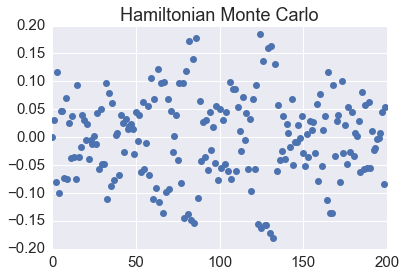

In [61]:

plt.title('Hamiltonian Monte Carlo')
plt.plot(range(len(current_q_list[:,0])), current_q_list[:,0], 'o')